# Анализ данных на Python

*Алла Тамбовцева* 

## Кластеризация количественных данных. Иерархический кластерный анализ: введение

Иерархический кластерный анализ решает задачу **классификации без обучения** на данных, распределение которых нам **неизвестно**. Другими словами, классический кластерный анализ распределяет имеющиеся в массиве данных наблюдения на группы, не предлагая при этом алгоритм для предсказания класса, к которому будет отнесено то или иное наблюдение. 

Для реализации иерархического кластерного анализа **на входе** необходимо иметь $p$-мерный массив данных (датафрейм из $n$ строк и $p$ столбцов), при этом заранее знать количество кластеров, которое мы хотим получить, необязательно.

**На выходе** получаем правило, которое позволяет наилучшим образом разбить имеющиеся наблюдения на однородные группы. Иерархический кластерный анализ не предлагает единственного решения, некоторого оптимального разбиения на кластеры, поэтому именно на исследователя возлагается задача выбрать наилучший вариант классификации. Тем не менее, однородность групп достигается довольно понятным образом, в кластерном анализе реализуется довольно распространённый для сравнения групп принцип: внутригрупповой разброс значений должен быть минимальным, а межгрупповой разброс – довольно существенным.

Почему этот тип кластерного анализа называется иерархическим? В основе данного вида кластерного анализа лежат **два предположения**:

1. На самом первом шаге кластерного анализа количество кластеров совпадает с количеством наблюдений (имеем $n$ кластеров, состоящих ровно из одного наблюдения).

2. Количество кластеров заранее неизвестно, мы объединяем точки в кластеры до тех пор, пока не получим один большой кластер. Так, на первом шаге иерархического кластерного анализа у нас есть $n$ кластеров, на втором шаге $(n − 1)$ кластеров, на третьем уже $(n − 2)$ кластеров, и так далее, а на последнем шаге остаётся один кластер. Другими словами, мы выстраиваем некоторую иерархию из кластеров, вложенных друг в друга, а потом решаем, на каком делении, более детальном (много маленьких кластеров) или более общем (мало больших кластеров), стоит остановиться.

**Пример.** Чтобы понять, какая идея стоит за алгоритмами реализации кластерного анализа, давайте рассмотрим следующую задачу. Пусть у нас есть небольшой двумерный массив данных, где $X$ – время, на которое преподаватель опаздывает на пару (в минутах), а $Y$ – время, на которое преподаватель опаздывает на личные встречи (в минутах):

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>X</th>
      <th>Y</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2</td>
      <td>6</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>8</td>
    </tr>
    <tr>
      <th>2</th>
      <td>8</td>
      <td>2</td>
    </tr>
    <tr>
      <th>3</th>
      <td>10</td>
      <td>3</td>
    </tr>
    <tr>
      <th>4</th>
      <td>5</td>
      <td>5</td>
    </tr>
  </tbody>
</table>

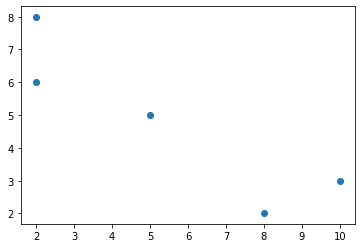

In [2]:
import numpy as np
from matplotlib import pyplot as plt

x = np.array([2, 2, 8, 10, 5])
y = np.array([6, 8, 2, 3, 5])

plt.scatter(x, y);

Возникает логичный вопрос: что нам понадобится, чтобы поделить все эти наблюдения на группы?

У иерархического кластерного анализа есть два **параметра кластеризации**:

1. **Метрика:** мера расстояния между наблюдениями.

2. **Метод агрегирования или агломерации:** алгоритм, который позволяет решать, каким образом объединять точки в кластеры на основе выбранной метрики.

На самом первом шаге иерархического кластерного анализа необходимости в методе агрегирования нет, мы просто однозначным образом определяем расстояние между всеми точками. Начиная со второго шага, однозначность теряется – как определить расстояние между группами точек? Можно посчитать расстояния между каждой точкой в первой группе и каждой точкой во второй группе и выбрать из них минимальное, а можно – максимальное. Наконец, можно, рассчитав расстояния между всеми парами точек, усреднить их... Cпособов много, у каждого свои достоинства и недостатки.

Примеры расстояний:

* [Евклидово расстояние](https://ru.wikipedia.org/wiki/%D0%95%D0%B2%D0%BA%D0%BB%D0%B8%D0%B4%D0%BE%D0%B2%D0%B0_%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B0#:~:text=%D0%95%D0%B2%D0%BA%D0%BB%D0%B8%D0%B4%D0%BE%D0%B2%D0%B0%20%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B0%20(%D0%B5%D0%B2%D0%BA%D0%BB%D0%B8%D0%B4%D0%BE%D0%B2%D0%BE%20%D1%80%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5)%20%E2%80%94,%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%B0%2C%20%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D1%8F%D0%B5%D0%BC%D0%BE%D0%B5%20%D0%BF%D0%BE%20%D1%82%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B5%20%D0%9F%D0%B8%D1%84%D0%B0%D0%B3%D0%BE%D1%80%D0%B0.), чаще всего используется для количественных данных.
* [Манхэттенское расстояние](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2), оно же блочное или расстояние городских кварталов, подходит для данных в бинарной шкале, а также для случаев, когда евклидово расстояние содержательно не очень применимо.
* [Расстояние Чебышёва](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%D0%B0), логика похожа на манхэттенское расстояние, но фокус на максимальных различиях.

Примеры методов агрегирования:

1. Метод ближнего соседа, он же метод одиночной связи (*single linkage*). Расстояние между двумя кластерами A и B определяется как расстояние между ближайшими точками этих кластеров.

2. Метод дальнего соседа, он же метод полной связи (*complete linkage*). Расстояние между двумя кластерами A и B определяется как расстояние между дальними точками этих кластеров.

3. Метод средней связи (*average linkage*). Расстояние между двумя кластерами A и B определяется как среднее расстояние между точками этих кластеров.

4. Метод центроидной связи (*centroid linkage*). Расстояние между двумя кластерами A и B определяется как расстояние между центроидами кластеров. Центроид – средний вектор кластера, его координаты считаются как средние арифметические соответствующих переменных.

5. Метод Варда, он же метод Уорда (*Ward’s linkage*). На каждом шаге обновления кластеров точка присоединяется к тому кластеру, присоединение к которому приводит к минимально возможному увеличению внутригрупповой дисперсии этого кластера.

Одним из самых эффективных методов агрегирования считается метод Варда, метод ближнего соседа имеет недостаток – склонен создавать кластеры, состоящие из одного наблюдения, метод центроидной связи может вызывать инверсию ситуацию, когда на последующем шаге кластеризации объединение в кластеры происходит на расстоянии меньшем, чем на предыдущем шаге. Метод дальнего соседа – достаточно хороший, без явных недостатков, используется по умолчанию в Python.

Вернёмся к нашим данным, объединим массивы `x` и `y` по столбцам в двумерный массив:

In [3]:
A = np.column_stack((x, y))
print(A)

[[ 2  6]
 [ 2  8]
 [ 8  2]
 [10  3]
 [ 5  5]]


Будем считать, что наблюдения в каждой строчке – это точки 0, 1, 2, 3, 4. Строго говоря, перед реализацией кластерного анализа нам нужно данные прошкалировать, например, центрировать и нормировать, чтобы все показатели были в единой безразмерной шкале, но пока пропустим этот этап, `x` и `y` измерены в минутах, плюс, порядок и разброс значений в этих столбцах примерно одинаковы.

Создадим матрицу расстояний для этих пяти точек с нуля. Сначала создадим квадратную матрицу из нулей:

In [4]:
# матрица 5 на 5

D = np.zeros((A.shape[0], A.shape[0]))
print(D)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


Импортируем из подмодуля `hierarchy` для иерархического кластерного анализа модуля `cluster` библиотеки `scipy` коллекцию функций `distance` для вычисления расстояний и напишем цикл, который заполнит элементы под главной диагональю матрицы значениями евклидового расстояниями между точками:

In [5]:
from scipy.cluster.hierarchy import distance

# функция euclidean()
# считаем попарные расстояния для уникальных пар

for i in range(0, A.shape[0]):
    for j in range(0, A.shape[0]):
        if i > j:
            D[i, j] = distance.euclidean(A[i], A[j]) 
print(D)

[[0.         0.         0.         0.         0.        ]
 [2.         0.         0.         0.         0.        ]
 [7.21110255 8.48528137 0.         0.         0.        ]
 [8.54400375 9.43398113 2.23606798 0.         0.        ]
 [3.16227766 4.24264069 4.24264069 5.38516481 0.        ]]


В целом, информации для реализации кластерного анализа уже достаточно, так как расстояние от точки до самой себя 0, и уникальные симметричные расстояния уже посчитаны. Но всё-таки сделаем матрицу полной – отразим её элементы относительно главной диагонали:

In [6]:
# функция fliplr() меняет порядок элементов (становятся справа налево)

np.fliplr(D)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 2.        ],
       [0.        , 0.        , 0.        , 8.48528137, 7.21110255],
       [0.        , 0.        , 2.23606798, 9.43398113, 8.54400375],
       [0.        , 5.38516481, 4.24264069, 4.24264069, 3.16227766]])

In [7]:
# функция rot90() отражает элементы («поворачивает» на 90 градусов)

np.rot90(np.fliplr(D))

array([[0.        , 2.        , 7.21110255, 8.54400375, 3.16227766],
       [0.        , 0.        , 8.48528137, 9.43398113, 4.24264069],
       [0.        , 0.        , 0.        , 2.23606798, 4.24264069],
       [0.        , 0.        , 0.        , 0.        , 5.38516481],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [8]:
# сложим матрицу с нижними и верхними элементами
# округлим ответы

D_ = (D + np.rot90(np.fliplr(D))).round(1)
print(D_)

[[0.  2.  7.2 8.5 3.2]
 [2.  0.  8.5 9.4 4.2]
 [7.2 8.5 0.  2.2 4.2]
 [8.5 9.4 2.2 0.  5.4]
 [3.2 4.2 4.2 5.4 0. ]]


Итак, матрица расстояний получена. На первом шаге кластеризации у нас будет пять кластеров по одной точке. На втором шаге в кластер будут объединены точки 0 и 1, так как это точки наиболее близки друг к другу (расстояние 2). На третьем шаге потребуется новая матрица расстояний, уже 4 на 4, нужно будет определить расстояния между кластером 0+1, точками 2, 3 и 4. И как раз тут и понадобится метод агрегирования, чтобы однозначно определить расстояние между кластером 0+1 и остальными точками. Не будем проделывать все эти манипуляции вручную, согласимся на метод дальнего соседа (полной связи) и импортируем функции `linkage()` и `dendgrogam()` из того же подмодуля `hierarchy` , чтобы получить результаты и визуализировать их.

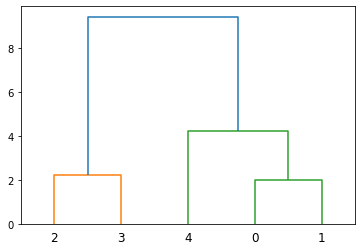

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram

# выбираем метод, метод агрегирования
# запускаем алгоритм и строим график

hc = linkage(A, metric = "euclidean", method = "complete")
dendrogram(hc);

Итак, в качестве визуализации мы построили **дендрограмму** – дерево, которое отображает все этапы объединения наблюдений в кластеры, от пяти групп до одной из всех точек сразу. Согласно дендрограмме, данные можно поделить на две группы (2+3 и 4+0+1) или на три группы (2+3, 4 и 0+1). Какой результат нас больше устроит, зависит от задачи и того, хотим ли мы получать в итоге кластеры из одного наблюдения. 

Python, например, считает, что две группы более предпочтительный вариант – исходя из расстояний между группами, он раскрасил ветки дендрограммы в два цвета. Чтобы понять, почему результат именно такой, посмотрим на содержимое `hc`:

In [10]:
print(hc)

[[0.         1.         2.         2.        ]
 [2.         3.         2.23606798 2.        ]
 [4.         5.         4.24264069 3.        ]
 [6.         7.         9.43398113 5.        ]]


Функция `linkage()` возвращает результаты в виде специфического массива размерности $(n-1)$ на 4, где $n$ – число наблюдений. Каждая строчка последовательно описывает каждый этап иерархической кластеризации – объединения точек. 

Первая строчка в `hc` описывает следующее: точка под номером 0 объединяется с точкой под номером 1 на расстоянии 2 в кластер, в этом кластере в итоге находятся два наблюдения. Вторая строчка в `hc` описывает следующий этап кластеризации: точка под номером 2 объединяется с точкой под номером 3 на расстоянии 2.23, в этом кластере тоже два наблюдения. А вот дальше точка 4 присоединяется к кластеру под номером 5 (Python сам пронумеровал созданный ранее кластер, точки имеют индексы от 0 до 4, он взял следующее число) на расстоянии 4.24, итого в кластере уже три наблюдения. Последняя строка соответствует завершающему этапу кластеризации – кластеры, пронумерованные Python числами 6 и 7, объединяются на расстоянии 9.43 и включают все пять наблюдений.

Теперь вернёмся к цветам кластеров, которое показывает предпочтительное деление на группы. Для получения такого разбиения по умолчанию используется значение `0.7 * max(hc[:, 2])`, где `max(hc[:, 2])` – максимальное из расстояний между кластерами, которое находится в третьем столбце `hc`. В нашем примере это 0.7 * 9.43 = 6.60. В целом, на эти значения можно ориентироваться, но всё же тут многое зависит от нашей задачи и содержательной информации о данных.

Это пороговое значение для выделения кластеров можно менять – так как от него зависят цвета, аргумент называется `color_threshold`:

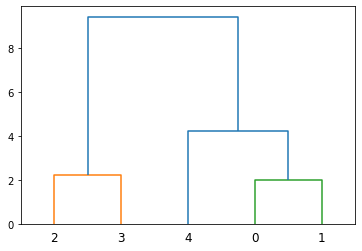

In [11]:
dendrogram(hc, color_threshold = 3);

При желании добавление разных цветов можно выключить (`color_threshold = 0`) и просто добавить горизонтальную линию.

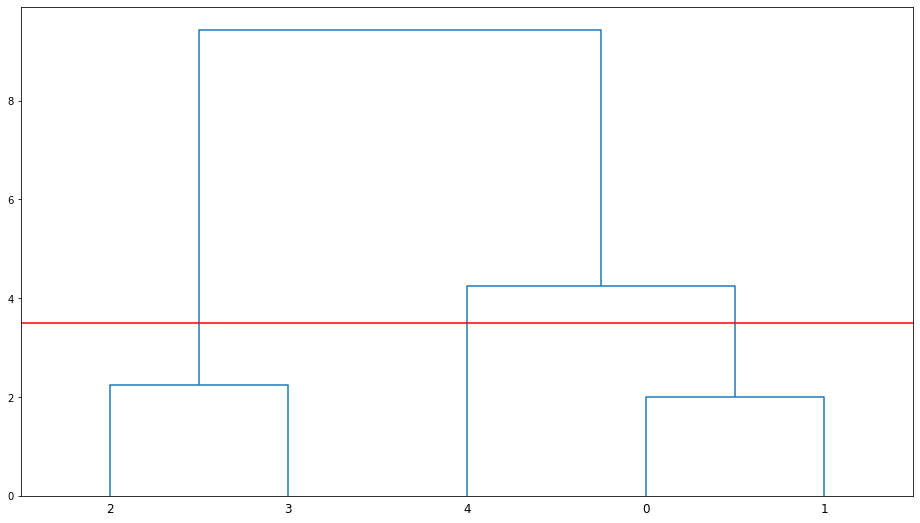

In [12]:
# резервируем место под график 16 на 9 дюймов
# строим дендрограмму, в тех же осях добавляем горизонтальную линию (hlines)
# линия на уровне y = 3.5 красного цвета 
# xmin и xmax – границы по оси X

plt.figure(figsize = (16, 9))
dendrogram(hc, color_threshold = 0)
plt.hlines(y = 3.5, xmin = 0, xmax = 50, color = "red");

Для полного счастья можем сделать линию пунктирной (аргумент `linestyle`) и добавить точки в местах «разрезания» дендрограммы:

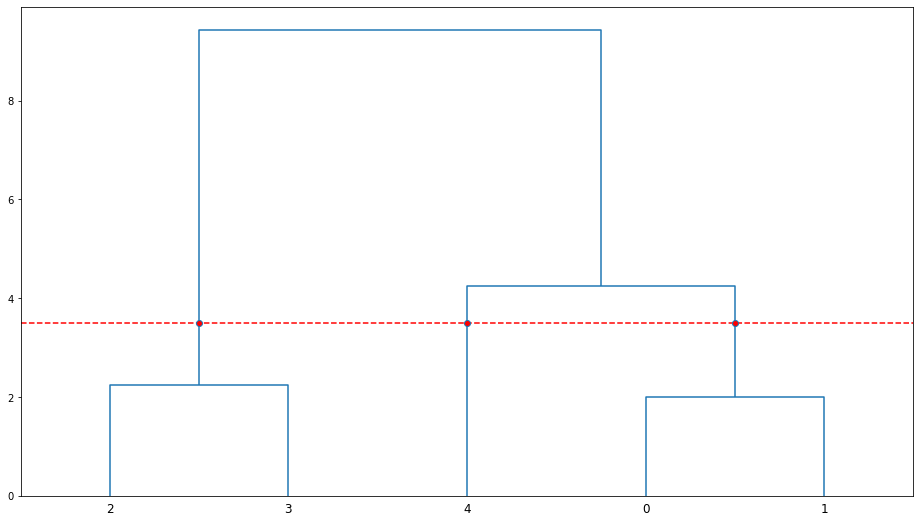

In [13]:
plt.figure(figsize = (16, 9))
dendrogram(hc, color_threshold = 0)
plt.hlines(y = 3.5, xmin = 0, xmax = 50, color = "red", linestyle = "dashed");

# на первом и втором местах – координаты точек по осям x и y
# marker – тип точки, color – цвет точки, markeredgecolor – цвет границ точки

plt.plot(10, 3.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(40, 3.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(25, 3.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");

Откуда взялись значения в `plot()`? Это координаты на основе точек для соединительных линий, сохранённых в объекте, который создаётся при построении дендрограммы. Если после строки с кодом для дендрограммы не ставить точку с запятой, мы его увидим:

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 2.23606797749979, 2.23606797749979, 0.0],
  [0.0, 2.0, 2.0, 0.0],
  [0.0, 4.242640687119285, 4.242640687119285, 2.0],
  [2.23606797749979, 9.433981132056603, 9.433981132056603, 4.242640687119285]],
 'ivl': ['2', '3', '4', '0', '1'],
 'leaves': [2, 3, 4, 0, 1],
 'color_list': ['C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C2', 'C2', 'C2']}

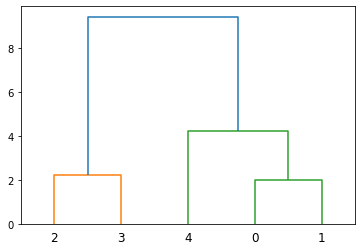

In [14]:
# icoord и dcoord – координаты для соединительных линий (веток дендрограммы)
dendrogram(hc)

Тут сложновато, разберём несколько точек. Возьмём первые два значения в первом списке в `icoord` и `dcoord`, это [5.0, 5.0] и [0.0, 2.23]. Если сформировать пары (5, 0) и (5, 2.23), получим две точки, если соединим эти точки на дендрограмме, получится вертикальная линия для «листа» с наблюдением под номером 2. Если проделаем это для следующих двух значений в тех же списках, получим точки (15, 2.23) и (15, 0), соединим их – получим вертикальную линию для «листа» с наблюдением под номером 3. Вторые списки в `icoord` и `dcoord` описывают вертикальные ветки для соединения точек 0 и 1, третьи – вертикальные ветки для соединения точки 4 и кластера из точек 0 и 1. Горизонтальные линии далее отрисовываются автоматически.

Теперь, если вернуться к координатам для красных точек на предыдущей дендрограмме, должно стать понятнее, почему значения по оси X именно 5, 15 и 30 :) А про типы и настройки точек можно почитать [здесь](https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html).

Ну, и для полного-полного счастья заменим индексы точек на какие-то свои названия (метки `labels`) и выгрузим дендрограмму в png-файл:

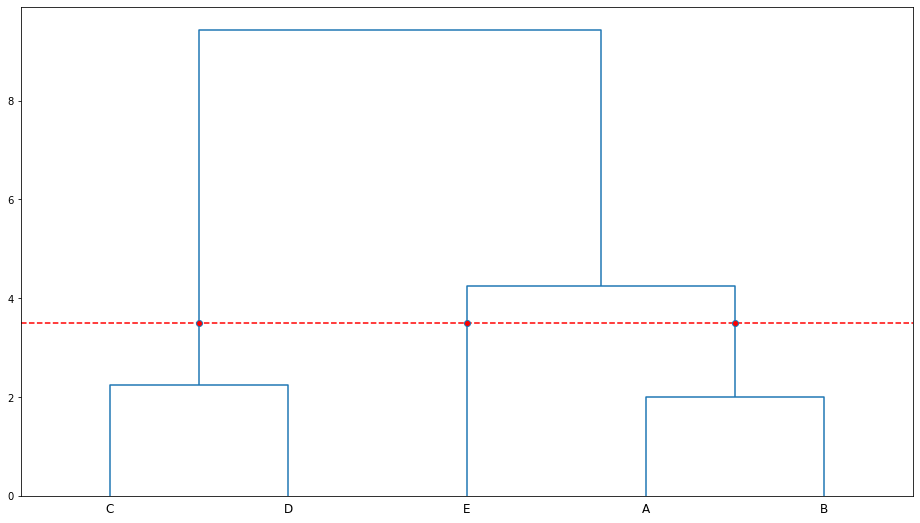

In [15]:
plt.figure(figsize = (16, 9))
dendrogram(hc, color_threshold = 0, labels = ["A", "B", "C", "D", "E"])
plt.hlines(y = 3.5, xmin = 0, xmax = 50, color = "red", linestyle = "dashed");

# на первом и втором местах – координаты точек по осям x и y
# marker – тип точки, color – цвет точки, markeredgecolor – цвет границ точки

plt.plot(10, 3.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(40, 3.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(25, 3.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");

plt.savefig("example00.png")

### Бонус: использование собственных матриц расстояний

Иногда возникает необходимость использовать уже готовые матрицы расстояний для дальнейшей реализации кластерного анализа. Это может быть связано с разными причинами: разработали свою метрику, которой нет в Python, нашли готовые данные по расстояниям для большого массива данных в интернете (пересчитывать заново затратно с точки зрения затрат времени и памяти), хочется сравнить результаты с учётом разных округлений расстояний... Глобальных проблем нет, но есть одна особенность функции `linkage()`, которую нужно учесть.

Готовая матрица расстояний (расстояния округлены) у нас уже есть – это `D_`:

In [18]:
print(D_)

[[0.  2.  7.2 8.5 3.2]
 [2.  0.  8.5 9.4 4.2]
 [7.2 8.5 0.  2.2 4.2]
 [8.5 9.4 2.2 0.  5.4]
 [3.2 4.2 4.2 5.4 0. ]]


Python, конечно, действует рационально, поэтому функция `linkage()` внутри создаёт не полную матрицу расстояний, а её компактную версию – элементы над главной даигональю. Что будет, если мы подадим ей на вход нашу матрицу `D_`, верную, но избыточную?

In [19]:
# метрику не прописываем – расстояния уже готовые
# а метод агрегирования по-прежнему обязателен

linkage(D_, method = 'complete')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


array([[ 0.        ,  1.        ,  3.39116499,  2.        ],
       [ 2.        ,  3.        ,  3.69052842,  2.        ],
       [ 4.        ,  5.        ,  8.43860178,  3.        ],
       [ 6.        ,  7.        , 16.12761607,  5.        ]])

Python выдал какой-то результат, не совсем корректный, и при этом вывел сообщение про «подозрительную» матрицу, которая выглядит как *uncondensed distance matrix*, то есть матрица расстояний в некомпактной форме. Как получить компактную форму (и заодно увидеть, какая она)? Воспользоваться функцией `squareform()` из того же набора `distance`:

In [20]:
distance.squareform(D_)

array([2. , 7.2, 8.5, 3.2, 8.5, 9.4, 4.2, 2.2, 4.2, 5.4])

Итак, всё просто: компактная форма матрицы расстояний – это просто набор её значений над главной диагональю! Что удобно, функция `squareform()` работает в две стороны: она может и симметричную матрицу свернуть в компактный вид, и компактную форму преобразовать в поноценную квадратную матрицу (она сама распознаёт, что ей подано на вход):

In [21]:
# для иллюстрации – применяем функцию дважды
# из короткой формы выше получили снова большую матрицу

distance.squareform(distance.squareform(D_))

array([[0. , 2. , 7.2, 8.5, 3.2],
       [2. , 0. , 8.5, 9.4, 4.2],
       [7.2, 8.5, 0. , 2.2, 4.2],
       [8.5, 9.4, 2.2, 0. , 5.4],
       [3.2, 4.2, 4.2, 5.4, 0. ]])

Финальный аккорд – подставляем компактную форму нашей матрицы в `linkage()` и сравниваем результаты с «автоматикой»:

In [22]:
hc2 = linkage(distance.squareform(D_), method = 'complete')
print(hc2)

[[0.  1.  2.  2. ]
 [2.  3.  2.2 2. ]
 [4.  5.  4.2 3. ]
 [6.  7.  9.4 5. ]]


In [23]:
print(hc)

[[0.         1.         2.         2.        ]
 [2.         3.         2.23606798 2.        ]
 [4.         5.         4.24264069 3.        ]
 [6.         7.         9.43398113 5.        ]]


Совпало, небольшие отличия расстояний ожидаемы, в `D_` были расстояния, округлённые до десятых. А значит, мы точно знаем, что порядок действий правильный, и матрицу `D_` мы можем формировать каким-то более интересным образом.